In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

import os
import shutil
import time
from tqdm import tqdm

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

2022-10-25 02:34:58.680514: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-25 02:34:58.680562: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
IMG_PATH = '/home/jupyter/gurih_mas/digit_recognizer/dataset/'
LABEL_PATH = '/home/jupyter/gurih_mas/digit_recognizer/labels/'
MODEL_PATH = '/home/jupyter/gurih_mas/digit_recognizer/models/'
RESULT_PATH = '/home/jupyter/gurih_mas/digit_recognizer/results/'

In [3]:
df_221018 = pd.read_csv(os.path.join(LABEL_PATH,'221018_dataset/221018_true_label.csv'), header=0, names=['ktp_pict','true_label'])
df_220930 = pd.read_csv(os.path.join(LABEL_PATH,'220930_dataset/220930_true_label.csv'), header=0, names=['ktp_pict','true_label'])
df_221018

,ktp_pict,true_label
0,5842d07e-418f-44ce-af86-0d13a5a8984a_6.jpg,6
1,4e7153a7-a7bf-4d4e-9ffd-a6ef2c84e1c3_3.jpg,2
2,5c030af6-5f52-4ef0-99c7-309e9d753f52_9.jpg,0
3,5c030af6-5f52-4ef0-99c7-309e9d753f52_10.jpg,0
4,00e1b1b4-a9b8-42ed-9dad-64c2c78e6ad2_0.jpg,7
...,...,...
4797,00271205-38de-4d83-8fad-3ca0475507be_3.jpg,9
4798,016c3300-c674-480c-87df-e4c8d9e0c9ba_5.jpg,9
4799,0147d75d-332d-414f-bd68-6ab46b89e1b0_10.jpg,9
4800,00178766-d1f9-406b-9e77-57dbc7ec5c42_10.jpg,9


In [4]:
df_220930

,ktp_pict,true_label
0,78d26390-6e2a-4bec-95d1-d3efc7d4302b_1.jpg,5.0
1,a6c278e3-b10a-49c0-a0ed-68afeba87032_15.jpg,5.0
2,f0693c55-27e1-4bbb-80ba-69e4281e2185_1.jpg,0.0
3,fe14e926-d3a1-4c09-898f-42c192bf6880_3.jpg,6.0
4,553b3fee-c37f-49ed-806b-2e8561b82807_0.jpg,3.0
...,...,...
4995,04f8c9f1-6a74-4cf0-907b-a334e1277e9b_5.jpg,4.0
4996,b5eebde8-5587-4325-8636-6d293560f9da_7.jpg,2.0
4997,27fa96a5-a3d2-49be-b4a8-9022542711ec_10.jpg,0.0
4998,6b753891-8fab-454a-9cc2-98735c9aff6d_12.jpg,0.0


In [5]:
df_220930 = df_220930[df_220930['true_label'].isin([0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0])] #Exclude NaN images
df_220930 = df_220930.astype({'true_label': int}) #Convert true_label classes from float to integer
df_220930 = df_220930.astype({'true_label': str}) #Convert true_label classes from integer to string

df_221018 = df_221018[df_221018['true_label'].isin([0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0])] #Exclude NaN images
df_221018 = df_221018.astype({'true_label': str}) #Convert true_label classes from integer to string

labels = df_221018.sort_values('true_label').reset_index(drop=True) #Extract the labels and store in a new data frame called labels
class_names = list(labels.true_label.unique()) #Create a Python list of Unique labels in data frame labels

In [6]:
df_220930.true_label.value_counts().sort_index() #Show data composition

0    1622
1     643
2     448
3     519
4     296
5     365
6     292
7     377
8     253
9     177
Name: true_label, dtype: int64

In [7]:
df_221018.true_label.value_counts().sort_index() #Show data composition

0    444
1    461
2    528
3    466
4    485
5    456
6    499
7    502
8    466
9    495
Name: true_label, dtype: int64

In [8]:
df_mix = pd.concat([df_221018, df_220930], axis=0)
df_mix = df_mix.sort_values(by=['true_label']).reset_index(drop=True)
df_mix

,ktp_pict,true_label
0,04f8c9f1-6a74-4cf0-907b-a334e1277e9b_7.jpg,0
1,02736e4f-377d-409f-8b96-fb8afa586626_7.jpg,0
2,76ab8710-67e9-4af5-b4dc-cb5a6985ba27_14.jpg,0
3,0192e499-c765-4033-9d37-ef361b8b6053_14.jpg,0
4,361cb483-1228-487d-8528-c4a9ffc595b5_14.jpg,0
...,...,...
9789,16efdc0e-655c-415d-ba27-f616594afb90_11.jpg,9
9790,01a84520-01f0-47f9-8402-edd1fa401ffa_3.jpg,9
9791,0505b9aa-7ddb-42ea-a83a-c407561a9ca6_10.jpg,9
9792,0078ce5d-bc96-40a7-8a9e-410d0b806bae_9.jpg,9


In [9]:
df_mix.true_label.value_counts().sort_index() #Show data composition

0    2066
1    1104
2     976
3     985
4     781
5     821
6     791
7     879
8     719
9     672
Name: true_label, dtype: int64

In [10]:
df_digit0 = df_mix[df_mix['true_label'].eq('0')]
df_digit0.drop(df_digit0.index[0:1396], inplace=True)

df_digit1 = df_mix[df_mix['true_label'].eq('1')]
df_digit1.drop(df_digit1.index[0:434], inplace=True)

df_digit2 = df_mix[df_mix['true_label'].eq('2')]
df_digit2.drop(df_digit2.index[0:306], inplace=True)

df_digit3 = df_mix[df_mix['true_label'].eq('3')]
df_digit3.drop(df_digit3.index[0:315], inplace=True)

df_digit4 = df_mix[df_mix['true_label'].eq('4')]
df_digit4.drop(df_digit4.index[0:111], inplace=True)

df_digit5 = df_mix[df_mix['true_label'].eq('5')]
df_digit5.drop(df_digit5.index[0:151], inplace=True)

df_digit6 = df_mix[df_mix['true_label'].eq('6')]
df_digit6.drop(df_digit6.index[0:121], inplace=True)

df_digit7 = df_mix[df_mix['true_label'].eq('7')]
df_digit7.drop(df_digit7.index[0:209], inplace=True)

df_digit8 = df_mix[df_mix['true_label'].eq('8')]
df_digit8.drop(df_digit8.index[0:49], inplace=True)

df_digit9 = df_mix[df_mix['true_label'].eq('9')]
df_digit9.drop(df_digit9.index[0:2], inplace=True)

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [11]:
#Concat KTP filenames into one DataFrame
df_dataset = pd.concat([df_digit0, df_digit1, df_digit2, df_digit3, df_digit4, df_digit5, df_digit6, df_digit7, df_digit8, df_digit9], axis=0).reset_index(drop=True)
df_dataset

,ktp_pict,true_label
0,7cff3c3d-8864-434a-b808-466240cb04a6_12.jpg,0
1,0569d11a-99ac-457f-b823-2978e5d4ce47_14.jpg,0
2,28161553-2df1-40f0-9159-e6eae9c68179_13.jpg,0
3,c86bdcc5-465a-4601-9c53-5e9af6fb94a4_4.jpg,0
4,6879ea39-ef2c-4100-b742-9fbfb846e7e4_13.jpg,0
...,...,...
6695,16efdc0e-655c-415d-ba27-f616594afb90_11.jpg,9
6696,01a84520-01f0-47f9-8402-edd1fa401ffa_3.jpg,9
6697,0505b9aa-7ddb-42ea-a83a-c407561a9ca6_10.jpg,9
6698,0078ce5d-bc96-40a7-8a9e-410d0b806bae_9.jpg,9


In [12]:
df_dataset.true_label.value_counts().sort_index() #Show data composition

0    670
1    670
2    670
3    670
4    670
5    670
6    670
7    670
8    670
9    670
Name: true_label, dtype: int64

In [13]:
df_dataset.to_csv('labelmix_dataset.csv',index=False)

In [14]:
split_ratio = 0.8
random_set = 10

#Split dataframe into multiple dataframe based on unique column values
dfdigit0 = df_dataset[df_dataset['true_label'] == '0']
dfdigit1 = df_dataset[df_dataset['true_label'] == '1']
dfdigit2 = df_dataset[df_dataset['true_label'] == '2']
dfdigit3 = df_dataset[df_dataset['true_label'] == '3']
dfdigit4 = df_dataset[df_dataset['true_label'] == '4']
dfdigit5 = df_dataset[df_dataset['true_label'] == '5']
dfdigit6 = df_dataset[df_dataset['true_label'] == '6']
dfdigit7 = df_dataset[df_dataset['true_label'] == '7']
dfdigit8 = df_dataset[df_dataset['true_label'] == '8']
dfdigit9 = df_dataset[df_dataset['true_label'] == '9']

#Sample image filename based on each labels
dftrain0 = dfdigit0.sample(frac=split_ratio, random_state=random_set)
dftest0 = dfdigit0.drop(dftrain0.index).reset_index(drop=True)
dftrain1 = dfdigit1.sample(frac=split_ratio, random_state=random_set)
dftest1 = dfdigit1.drop(dftrain1.index).reset_index(drop=True)
dftrain2 = dfdigit2.sample(frac=split_ratio, random_state=random_set)
dftest2 = dfdigit2.drop(dftrain2.index).reset_index(drop=True)
dftrain3 = dfdigit3.sample(frac=split_ratio, random_state=random_set)
dftest3 = dfdigit3.drop(dftrain3.index).reset_index(drop=True)
dftrain4 = dfdigit4.sample(frac=split_ratio, random_state=random_set)
dftest4 = dfdigit4.drop(dftrain4.index).reset_index(drop=True)
dftrain5 = dfdigit5.sample(frac=split_ratio, random_state=random_set)
dftest5 = dfdigit5.drop(dftrain5.index).reset_index(drop=True)
dftrain6 = dfdigit6.sample(frac=split_ratio, random_state=random_set)
dftest6 = dfdigit6.drop(dftrain6.index).reset_index(drop=True)
dftrain7 = dfdigit7.sample(frac=split_ratio, random_state=random_set)
dftest7 = dfdigit7.drop(dftrain7.index).reset_index(drop=True)
dftrain8 = dfdigit8.sample(frac=split_ratio, random_state=random_set)
dftest8 = dfdigit8.drop(dftrain8.index).reset_index(drop=True)
dftrain9 = dfdigit9.sample(frac=split_ratio, random_state=random_set)
dftest9 = dfdigit9.drop(dftrain9.index).reset_index(drop=True)

In [15]:
#Concat train and test filenames into one DataFrame
df_train = pd.concat([dftrain0, dftrain1, dftrain2, dftrain3, dftrain4, dftrain5, dftrain6, dftrain7, dftrain8, dftrain9], axis=0).reset_index(drop=True)
df_test = pd.concat([dftest0, dftest1, dftest2, dftest3, dftest4, dftest5, dftest6, dftest7, dftest8, dftest9], axis=0).reset_index(drop=True)

In [16]:
df_train

,ktp_pict,true_label
0,088b23c2-dfdc-4090-a1ae-22aae8ce2599_10.jpg,0
1,cf9a4752-7a27-4421-8e28-024e7c92dc9e_14.jpg,0
2,036fbfb3-0125-456d-aca9-06829b6da2e6_12.jpg,0
3,78f19620-aeca-4791-a12e-9dcecd60a220_17.jpg,0
4,012c8806-1ce2-4f11-a961-fd966e5a898d_8.jpg,0
...,...,...
5355,9cee6a8a-d34d-41a9-b367-2b79a49d3aef_7.jpg,9
5356,98b24f63-5371-4e13-9b57-8886079b1613_5.jpg,9
5357,03786aa6-d6b6-47d7-b1a1-42be0726b0f7_5.jpg,9
5358,9e3bdd26-8fd4-48ae-8fa3-d1b7bc761ca8_2.jpg,9


In [17]:
df_test

,ktp_pict,true_label
0,6879ea39-ef2c-4100-b742-9fbfb846e7e4_13.jpg,0
1,6217b74d-3ca1-47b6-9a18-ceccfcf55e7b_13.jpg,0
2,552cd17f-a39c-4536-a348-003ac74f9317_10.jpg,0
3,10b189c6-8a5a-400d-9734-1800be3466d4_13.jpg,0
4,10b189c6-8a5a-400d-9734-1800be3466d4_2.jpg,0
...,...,...
1335,484e3d49-749d-4bec-9353-19d95f420367_9.jpg,9
1336,33ae2f86-4440-4238-a1c4-a340691447a7_7.jpg,9
1337,276511f8-1316-4d66-bd4d-7c0900ed4d14_12.jpg,9
1338,9d2b0028-cdc4-4f78-856e-8dd4e8f602c9_9.jpg,9


In [18]:
df_train['image_flag'] = "train"
df_test['image_flag'] = "test"
image_flag = ["train","test"]

In [19]:
for f in image_flag:
    for i in class_names:
        if os.path.isdir(os.path.join('/home/jupyter/gurih_mas/digit_recognizer/dataset/mix_dataset',f,i)) == False:
            os.makedirs(os.path.join('/home/jupyter/gurih_mas/digit_recognizer/dataset/mix_dataset',f,i))
        else:
            pass

In [20]:
for c in class_names:
    for i in list(df_train[df_train['true_label']==c]['ktp_pict']):
        # Create path to the image 
        get_image = os.path.join('/home/jupyter/gurih_mas/digit_recognizer/dataset/mix_raw',i)
        # If image has not already exist in the new folder create one        
        if os.path.isfile('/home/jupyter/gurih_mas/digit_recognizer/dataset/mix_dataset/train/{}/{}'.format(c,i)) == False:
            # Copy the image 
            copy_image_to_class_folder = shutil.copy(get_image,'/home/jupyter/gurih_mas/digit_recognizer/dataset/mix_dataset/train/{}'.format(c))
        else:
            pass

In [21]:
for c in class_names:
    for i in list(df_test[df_test['true_label']==c]['ktp_pict']):
        # Create path to the image 
        get_image = os.path.join('/home/jupyter/gurih_mas/digit_recognizer/dataset/mix_raw',i)
        # If image has not already exist in the new folder create one        
        if os.path.isfile('/home/jupyter/gurih_mas/digit_recognizer/dataset/mix_dataset/test/{}/{}'.format(c,i)) == False:
            # Copy the image 
            copy_image_to_class_folder = shutil.copy(get_image,'/home/jupyter/gurih_mas/digit_recognizer/dataset/mix_dataset/test/{}'.format(c))
        else:
            pass

In [22]:
df_train.to_csv('/home/jupyter/gurih_mas/digit_recognizer/labels/mixdataset_train.csv',index=False)
df_test.to_csv('/home/jupyter/gurih_mas/digit_recognizer/labels/mixdataset_test.csv',index=False)

### Loading dataset

In [23]:
TRAIN_PATH = '/home/jupyter/gurih_mas/digit_recognizer/dataset/mix_dataset/train'
TEST_PATH = '/home/jupyter/gurih_mas/digit_recognizer/dataset/mix_dataset/test'

batch_size = 32
img_height = 160
img_width = 160

train_ds = tf.keras.utils.image_dataset_from_directory(
  TRAIN_PATH,
  validation_split=None,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode='int')

Found 5287 files belonging to 10 classes.


2022-10-25 02:35:01.374222: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-10-25 02:35:01.374274: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-10-25 02:35:01.374313: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (addin-gurihmas-dev): /proc/driver/nvidia/version does not exist
2022-10-25 02:35:01.374724: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [24]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  TEST_PATH,
  validation_split=None,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode =  'int')

Found 1336 files belonging to 10 classes.


In [25]:
# Extract train file
file_train_paths = train_ds.file_paths
file_train = pd.DataFrame(file_train_paths)
file_train.columns = ['filename']
print(file_train.shape)
file_train.head()

(5287, 1)


,filename
0,/home/jupyter/gurih_mas/digit_recognizer/datas...
1,/home/jupyter/gurih_mas/digit_recognizer/datas...
2,/home/jupyter/gurih_mas/digit_recognizer/datas...
3,/home/jupyter/gurih_mas/digit_recognizer/datas...
4,/home/jupyter/gurih_mas/digit_recognizer/datas...


In [26]:
filename_train = file_train.filename.str.rsplit("/", n=8, expand=True)
filename_train.columns = ['dir_1','dir_2','dir_3','dir_4','dir_5','dir_6','dir_7','dir_8','dir_9']

label_list = []
filename_train = filename_train[['dir_9','dir_8']]
for index,row in filename_train.iterrows():
    if row['dir_8'] == '0':
        label_list.append(0)
    elif row['dir_8'] == '1':
        label_list.append(1)
    elif row['dir_8'] == '2':
        label_list.append(2)
    elif row['dir_8'] == '3':
        label_list.append(3)
    elif row['dir_8'] == '4':
        label_list.append(4)
    elif row['dir_8'] == '5':
        label_list.append(5)
    elif row['dir_8'] == '6':
        label_list.append(6)
    elif row['dir_8'] == '7':
        label_list.append(7)
    elif row['dir_8'] == '8':
        label_list.append(8)
    elif row['dir_8'] == '9':
        label_list.append(9)

filename_train.columns=['filename','label']
filename_train['label'] = label_list
filename_train = filename_train.reset_index(drop=True)
print(filename_train.shape)
filename_train.head()

(5287, 2)


,filename,label
0,93345017-3b27-4999-8ae4-f0518dd8278b_2.jpg,2
1,ec81e81e-1672-40f6-9f1c-f3712ba2b7a7_3.jpg,8
2,044612d3-4269-465b-bd20-cb0b9119ab25_5.jpg,8
3,017d9a15-f72a-4279-87f5-79c10686ce79_6.jpg,8
4,1024566e-ef18-4b49-9560-0c18f7b8dc32_0.jpg,1


In [27]:
classes = train_ds.class_names
print(classes)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


2022-10-25 02:35:27.512276: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


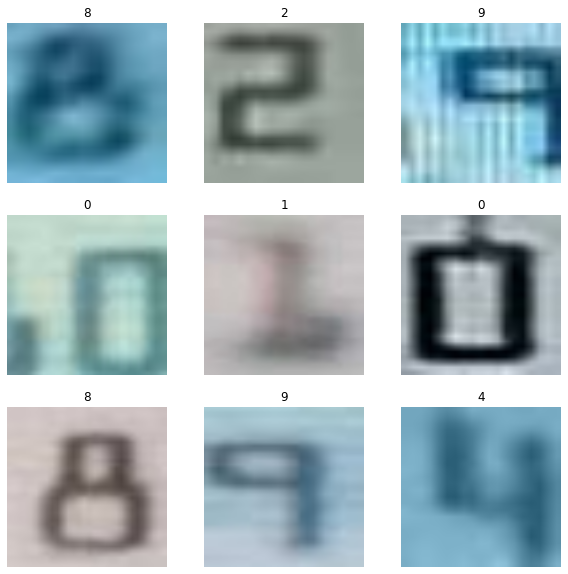

In [28]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        # plt.title(class_names[labels[i]])
        plt.title(labels[i].numpy())
        plt.axis("off")

In [29]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_ds))

Number of validation batches: 42


In [31]:
print('Number of train batches: %d' % tf.data.experimental.cardinality(train_ds))

Number of train batches: 166


In [32]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

In [33]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [34]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [35]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SIZE = (160,160)
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [36]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [37]:
base_model.trainable = False

In [38]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 80, 80, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [39]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [40]:
prediction_layer = tf.keras.layers.Dense(len(class_names),activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 10)


In [41]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [42]:
base_learning_rate = 0.0001

model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              metrics=['accuracy'])

In [43]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                12810 

In [44]:
len(model.trainable_variables)

2

In [45]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(val_ds)

/opt/conda/lib/python3.7/site-packages/keras/backend.py:4907: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


42/42 [==============================] - 14s 287ms/step - loss: 2.8082 - accuracy: 0.0726


In [46]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 2.81
initial accuracy: 0.07


In [47]:
ts = time.time()
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds)
print("Finished in {} s".format(time.time() - ts))

Epoch 1/10
166/166 [==============================] - 62s 356ms/step - loss: 2.2652 - accuracy: 0.2113 - val_loss: 1.6832 - val_accuracy: 0.4753
Epoch 2/10
166/166 [==============================] - 58s 351ms/step - loss: 1.5596 - accuracy: 0.4922 - val_loss: 1.2435 - val_accuracy: 0.6729
Epoch 3/10
166/166 [==============================] - 58s 350ms/step - loss: 1.2099 - accuracy: 0.6274 - val_loss: 1.0094 - val_accuracy: 0.7455
Epoch 4/10
166/166 [==============================] - 58s 348ms/step - loss: 1.0223 - accuracy: 0.6996 - val_loss: 0.8669 - val_accuracy: 0.7822
Epoch 5/10
166/166 [==============================] - 59s 353ms/step - loss: 0.8951 - accuracy: 0.7361 - val_loss: 0.7697 - val_accuracy: 0.8046
Epoch 6/10
166/166 [==============================] - 58s 350ms/step - loss: 0.8069 - accuracy: 0.7755 - val_loss: 0.7008 - val_accuracy: 0.8189
Epoch 7/10
166/166 [==============================] - 58s 352ms/step - loss: 0.7332 - accuracy: 0.7940 - val_loss: 0.6474 - val_ac

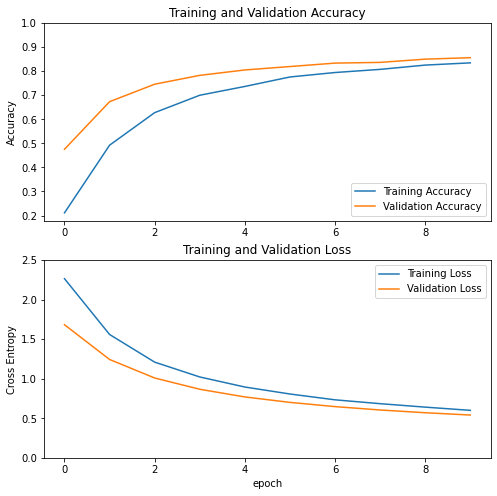

In [48]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,2.5])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [49]:
base_model.trainable = True

In [50]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [51]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
          optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
          metrics=['accuracy'])

In [52]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                12810 

In [53]:
len(model.trainable_variables)

56

In [54]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

ts = time.time()
history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_ds)
print("Finished in {} s".format(time.time() - ts))

Epoch 10/20
166/166 [==============================] - 96s 556ms/step - loss: 0.3452 - accuracy: 0.8929 - val_loss: 0.1097 - val_accuracy: 0.9663
Epoch 11/20
166/166 [==============================] - 95s 575ms/step - loss: 0.0860 - accuracy: 0.9730 - val_loss: 0.0653 - val_accuracy: 0.9813
Epoch 12/20
166/166 [==============================] - 95s 570ms/step - loss: 0.0431 - accuracy: 0.9890 - val_loss: 0.0357 - val_accuracy: 0.9918
Epoch 13/20
166/166 [==============================] - 92s 557ms/step - loss: 0.0279 - accuracy: 0.9921 - val_loss: 0.0330 - val_accuracy: 0.9895
Epoch 14/20
166/166 [==============================] - 96s 580ms/step - loss: 0.0184 - accuracy: 0.9949 - val_loss: 0.0421 - val_accuracy: 0.9903
Epoch 15/20
166/166 [==============================] - 93s 559ms/step - loss: 0.0178 - accuracy: 0.9945 - val_loss: 0.1320 - val_accuracy: 0.9603
Epoch 16/20
166/166 [==============================] - 94s 567ms/step - loss: 0.0164 - accuracy: 0.9951 - val_loss: 0.0218 -

In [55]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

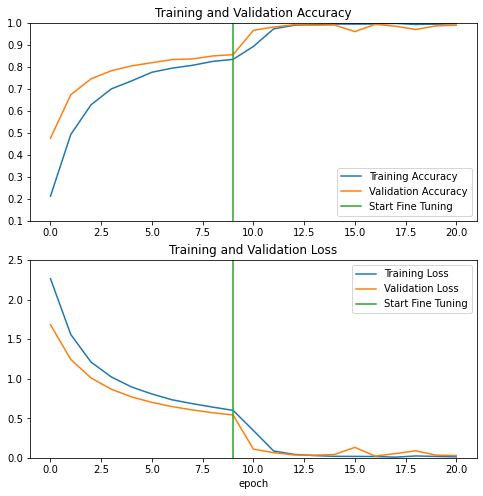

In [56]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.1, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 2.5])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [57]:
loss, accuracy = model.evaluate(val_ds)
print('Test accuracy :', accuracy)

42/42 [==============================] - 11s 264ms/step - loss: 0.0288 - accuracy: 0.9895
Test accuracy : 0.9895209670066833


In [58]:
# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
model.save(os.path.join(MODEL_PATH,'DR_MobileNetV2_v3.1.h5'))

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
